# Style Transfer with Deep Neural Networks - Keras

Welcome to this notebook! We are going to recreate the style transfer method in this paper [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using Keras. 

In the paper, style transfer uses the features found in the VGG19 Network. The structurer of this network is below:

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

The final result looks like this:

<img src='notebook_ims/Example.png' width=80% />


Basically, the steps are:
- 1- Take an image to keep the content (a selfie, or something like that)
- 2- Take an image to take the style (like a painting)

(We are going to take the style and try to apply it into the content image)

- 3- Take our pretrained network VGG19
- 4- Create new loss function (one for each type of image: content and style)
- 5- Finally, try to minimize the loss function

We use VGG19, as suggested in the paper. Since VGG19 is"relatively simple model" (compared with ResNet, Inception, etc) the feature maps actually work better for style transfer.

In [1]:
from keras.applications import VGG19
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.contrib.keras.api.keras.applications import vgg19
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from tensorflow.python.keras import models 
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.python.keras.preprocessing import image as kp_image

from PIL import Image
import matplotlib.pyplot as plt
from scipy.misc import imsave, imresize
import numpy as np

Using TensorFlow backend.


## Get images

In [2]:
content_image_path = './images/roscon_1.jpg'
style_image_path = './images/hockney.jpg'

# Change the weights to other values
content_weight = 0.01
style_weight = 1.0
variation_weight = 1.0
img_channels = 3

Text(0.5,1,'STYLE')

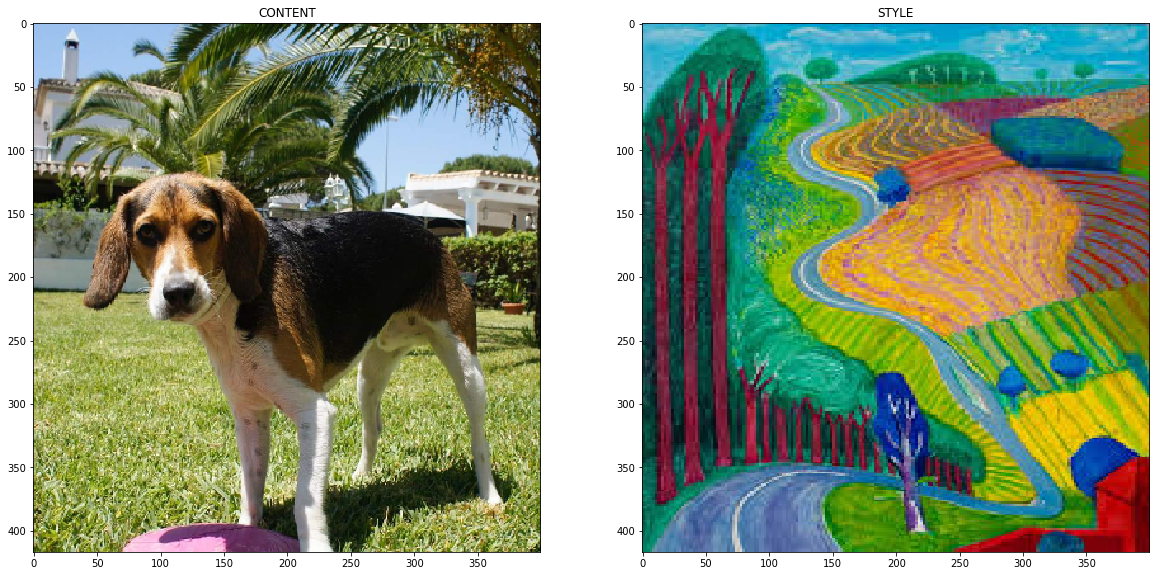

In [3]:
# Show the images
content_img = load_img(content_image_path)
style_img = load_img(style_image_path)

h, w = load_img(content_image_path).size
resize_h = 400
resize_w = int(h * resize_h / w)
img_size = resize_h * resize_w

content_img = content_img.resize((resize_h, resize_w))
style_img = style_img.resize((resize_h, resize_w))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(content_img)
ax1.set_title('CONTENT')
ax2.imshow(style_img)
ax2.set_title('STYLE')

## Create functions to preprocess images

In [4]:
# Preprocess images to prepare them as input to the network
def preprocess(img_path):
    # Load the image
    img = load_img(img_path)
    # To array
    img = img_to_array(img)

    # Resize array to resize_h, resize_w
    img = imresize(img, (resize_h, resize_w, 3)).astype('float64')
    
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# This is the inverse process to visualize the image
def deprocess(img):

    img = img.reshape((resize_h, resize_w, 3))
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

## Define Layers Model

We are going to define the intermediate layers and then we are going to use them to extract information and perform our style transfer. You can find more information about why we are choosing these layers in the original paper: 

[Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

## Content Loss

The main objective of the content loss is to measure whether the generated image retains the global characteristics of the content image. In this case, we want to make sure that the generated image looks like the girl on the picture, so the shapes as the face, eyes, etc... must be recognizable. Basically, we use the content loss function to measure how correct its performance is, using the mean squared error between the feature representations of p and x, respectively, at a given layer l.

<img src='notebook_ims/cont_loss_0.png' width=50% />

Mathematically, we can say:

<img src='notebook_ims/cont_loss_1.png' width=50% />

Where $C_{c}$ contains the feature representation of x for layer l, and $T_{c}$ is the feature representation of p for layer l.

In [5]:
def content_loss(content_features, generated_features):
    """
    Computes the content loss
    
    Arguments:
        content_features: Features of the content image
        generated_features: Features of the generated image
        
    Returns:
        Content Loss
    """
    return K.sum(K.square(generated_features - content_features))

## Style Loss

The style loss is designed to preserve the stylistic characteristics of the style image. We need to use a matrix called `Gram Matrix`, is a square matrix that contains the dot products between each vectorized filter in layer l. We can thought of as a non-normalized correlation matrix for filters in layer l.

<img src='notebook_ims/gram_matrix_1.png' width=50% />

<img src='notebook_ims/gram_matrix_2.png' width=50% />

So, mathematically:

<img src='notebook_ims/style_loss_1.png' width=50% />

where $S_{s,i}$ is the Gram matrix for the style image and $T_{s,i}$ is the Gram matrix for the generated image x.

In [6]:
def gram_matrix(features):
    """
    Calculates the gram matrix 
    Arguments:
        features: The feature matrix is used to calculate the gram matrix
        
    Returns:
        Gram Matrix
    """
    return K.dot(features, K.transpose(features))

In [7]:
def style_loss(style_matrix, generated_matrix):
    """
    Computes the style loss 
    
    Arguments:
        style_matrix: Style representation from the target style image
        generated_matrix: Style representation from the generated image
    Returns:
        Style Loss
    """
    # Permute the matrix to calculate proper covariance
    style_features = K.batch_flatten(K.permute_dimensions(style_matrix, (2, 0, 1)))
    generated_features = K.batch_flatten(K.permute_dimensions(generated_matrix, (2, 0, 1)))

    # Get the gram matrices
    style_mat = gram_matrix(style_features)
    generated_mat = gram_matrix(generated_features)

    return K.sum(K.square(style_mat - generated_mat)) / (4.0 * (img_channels ** 2) * (img_size ** 2))

In [8]:
def variation_loss(generated_matrix):
    """
    Computes the variation loss metric - normalization
    
    Arguments:
        generated_matrix: The generated matrix
    Returns:
        The variation loss term for normalization
    """
    
    a = K.square(generated_matrix[:, :resize_h-1, :resize_w-1, :] - generated_matrix[:, 1:, :resize_w-1, :])
    b = K.square(generated_matrix[:, :resize_h-1, :resize_w-1, :] - generated_matrix[:, :resize_h-1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

## Evaluator

We create an evaluator, if we look into the Keras Documentation, we can see how we can create a new one or also we take one from Keras.

In [9]:
# From Keras Documentation

def eval_loss_and_grads(x):
    x = x.reshape((1, resize_h, resize_w, 3))
    # Update the loss and the gradients
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    """
    Evaluator class used to track gradients and loss values together
    """

    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [10]:
# Prepare the variables for the flow graph
content_image = K.variable(preprocess(content_image_path))
style_image = K.variable(preprocess(style_image_path))
generated_image = K.placeholder((1, resize_h, resize_w, 3))

content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

def get_features_loss(content_image, style_image, generated_image):
    # Create the input tensor with content_matrix, style_matrix and generated_matrix
    input_tensor = K.concatenate([content_image, style_image, generated_image], axis=0)
    # Initializer the model VGG19
    model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

    # Layers to dictionary
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    # Calculate content_loss. Take into account that:
    # - content_layers[0, ...] = content image features
    # - content_layers[1, ...] = style image features
    # - content_layers[2, ...] = generated image features
    loss = 0.
    content_layers = outputs_dict[content_layer]
    content_img_features = content_layers[0, :, :, :]
    gen_img_features = content_layers[2, :, :, :]
    loss += content_weight * content_loss(content_img_features, gen_img_features)
    
    # How in style_features we have a lot of layers: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    # We have to do the same thing that in content_layer and calculate the loss.
    for name in style_layers:
        style_layer = outputs_dict[name]
        style_features = style_layer[1, :, :, :]
        gen_img_features = style_layer[2, :, :, :]
        s1 = style_loss(style_features, gen_img_features)
        # We need to devide the loss by the number of layers that we take into account
        loss += (style_weight / len(style_layers)) * s1
    loss += variation_weight * variation_loss(generated_image)
    
    return loss

loss = get_features_loss(content_image, style_image, generated_image)


C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [11]:
grads = K.gradients(loss, generated_image)

# Define the output
outputs = [loss]
outputs += grads
f_outputs = K.function([generated_image], outputs)

evaluator = Evaluator()
iterations = 3

In [12]:
import time

# Define x 
x = preprocess(content_image_path)

for i in range(iterations):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=300)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess(x)
    imsave('./results/img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


Step 0
    loss: 326681472.0
     Image saved. Time: 74.09835910797119
Step 1


C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


    loss: 404089280.0
     Image saved. Time: 69.55408930778503
Step 2
    loss: 446034368.0
     Image saved. Time: 69.30062866210938
